In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest

In [2]:
df = pd.read_csv('/home/nader/Desktop/GNSS/gnss_dataset.csv', sep=',', header=0)
print("Shape:", df.shape)
df.head()


Shape: (64800, 721)


,CNR_sat0_t0,CNR_sat0_t1,CNR_sat0_t2,CNR_sat0_t3,CNR_sat0_t4,CNR_sat0_t5,CNR_sat0_t6,CNR_sat0_t7,CNR_sat0_t8,CNR_sat0_t9,...,SignalPower_sat7_t21,SignalPower_sat7_t22,SignalPower_sat7_t23,SignalPower_sat7_t24,SignalPower_sat7_t25,SignalPower_sat7_t26,SignalPower_sat7_t27,SignalPower_sat7_t28,SignalPower_sat7_t29,label
0,18.406781,0.000000,20.218603,0.000000,17.564871,24.303350,17.551873,22.115032,22.135303,17.804283,...,-149.487596,-160.186617,-153.496117,-163.728477,-151.048771,-163.132984,-146.793844,-166.466171,-160.819247,2
1,49.014528,49.031546,50.206019,47.890148,48.638180,49.520329,49.679291,48.980822,49.021366,48.374771,...,-124.236870,-124.538802,-126.152666,-126.903856,-127.881011,-124.512248,-126.233466,-125.910274,-125.875064,1
2,49.373822,48.468438,49.818764,49.059569,49.688190,49.516493,48.934207,49.104185,49.376770,48.741280,...,-124.854561,-126.229613,-125.761595,-123.998128,-126.450095,-126.130294,-125.660239,-125.241437,-125.768018,1
3,48.814484,48.310053,48.023966,47.841300,48.442047,47.725688,47.092335,49.057910,47.179795,48.934514,...,-125.561227,-124.077280,-125.900909,-126.411518,-124.581620,-128.486710,-126.044688,-126.742556,-125.346637,1
4,45.722453,47.143056,46.899661,46.686840,46.253347,46.393121,47.217297,46.869686,48.172847,46.753115,...,-127.879255,-126.698875,-126.997468,-127.484429,-128.025621,-126.943031,-127.380110,-126.637514,-125.576804,1


Signal features extracted from GNSS (Global Navigation Satellite System) observations are used to detect spoofing and jamming attacks. Each row represents a single sample with signal characteristics measured from 8 different satellites (sat0 to sat7) over 30 consecutive time steps (t0 to t29). There are three main types of features being captured for each satellite-time combination: the carrier-to-noise ratio (CNR), the Doppler shift, and the signal power. By spoofing or jamming, these features may be affected, including signal strength, frequency deviation due to relative motion, and received signal power. For each sample, there are 720 feature columns (3 features × 8 satellites × 30 time steps), followed by a label column indicating the ground truth class: 0 for normal signals, 1 for spoofed signals, and 2 for jammed signals. The rich multivariate dataset enables both traditional machine learning models and deep learning architectures to identify temporal and spatial patterns indicative of GNSS signal integrity or interference.

<Axes: title={'center': 'Sample Count per Class'}, xlabel='label_name'>

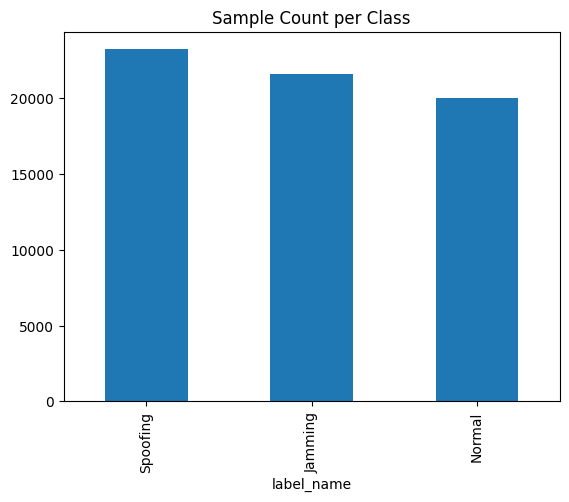

In [3]:
class_map = {0: 'Normal', 1: 'Spoofing', 2: 'Jamming'}
df['label_name'] = df['label'].map(class_map)
df['label_name'].value_counts().plot(kind='bar', title='Sample Count per Class')

This bar chart of samples counts for each class that represents the number of data samples in each category: Spoofing, Jamming, and Normal GNSSs. 

Each bar's height shows how many observations belong to that class. In this dataset, the bars are relatively close in height (on the order of tens of thousands of samples each), indicating that the three classes are nearly balanced. Spoofing has the highest count (slightly above 20,000 samples), Jamming is a close second, and Normal has somewhat fewer samples (just under 20,000). The bars are all of the same color (blue) with class labels on the x-axis, emphasizing overall class frequencies without a per-class color distinction.

The near-balance in class counts suggests that the dataset provides a comparable quantity of data for Normal, Jamming, and Spoofing conditions. This is advantages for training ML models because it reduces bias for each class. It seems that no one of classes is severely underrepresented. In the context of GNSS interference research, this balanced distribution means performance metrics can be trusted to reflect true performance on each type of signal condition, rather than being skewed by class imbalance. Therefore, the class distribution indicates a well-prepared dataset with ample instances of both spoofing and jamming events relative to normal signals.

### Missing Data Heatmap

In [4]:
# Filter only columns with missing values
missing_cols = df.columns[df.isnull().any()].tolist()


if missing_cols:
    plt.figure(figsize=(20, 2))
    sns.heatmap(df[missing_cols].isnull().sample(n=500, random_state=42),
                cbar=False, cmap="viridis", yticklabels=False)
    plt.title("Missing Data (only columns with NaNs)")
    plt.xlabel("Features with Missing Values")
    plt.ylabel("Sample Rows")
    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing values found in any column!")


✅ No missing values found in any column!


In [5]:
df.describe().T.head(10)      

,count,mean,std,min,25%,50%,75%,max
CNR_sat0_t0,64800.0,36.750743,16.376582,0.0,20.591106,44.629325,49.270519,64.833662
CNR_sat0_t1,64800.0,36.783811,16.330710,0.0,20.670336,44.570914,49.294515,64.954760
CNR_sat0_t2,64800.0,36.795607,16.350917,0.0,20.707023,44.687848,49.275922,64.988953
CNR_sat0_t3,64800.0,36.783286,16.338762,0.0,20.530545,44.608801,49.290146,64.711533
CNR_sat0_t4,64800.0,36.777342,16.359629,0.0,20.692884,44.624563,49.277315,64.992133
CNR_sat0_t5,64800.0,36.752715,16.369503,0.0,20.601020,44.585927,49.270864,64.606944
CNR_sat0_t6,64800.0,36.722154,16.396294,0.0,20.679138,44.577615,49.244204,64.644084
CNR_sat0_t7,64800.0,36.803358,16.297796,0.0,20.771948,44.629797,49.259595,64.574801
CNR_sat0_t8,64800.0,36.776136,16.348019,0.0,20.720436,44.590515,49.259935,64.897761
CNR_sat0_t9,64800.0,36.773980,16.368296,0.0,20.671429,44.610115,49.278526,64.714076


### Distribution of C/N₀ Values Across Classes

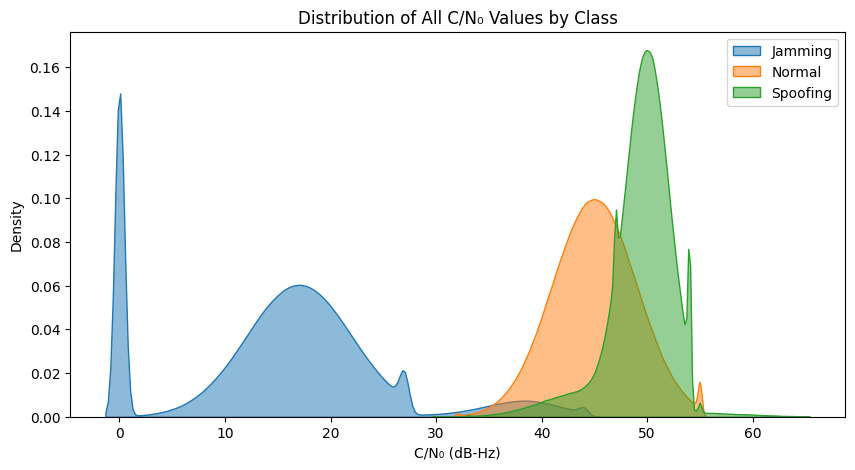

In [6]:
cnr_cols = [col for col in df.columns if 'CNR' in col]
plt.figure(figsize=(10,5))
for label, group in df.groupby('label_name'):
    vals = group[cnr_cols].values.flatten()
    sns.kdeplot(vals, label=label, fill=True, alpha=0.5)
plt.title("Distribution of All C/N₀ Values by Class")
plt.xlabel("C/N₀ (dB-Hz)")
plt.legend()
plt.show()


This combined C/N₀ histogram illustrates how signal quality differs under interference versus normal operation. Jamming causes a drastic reduction in carrier-to-noise ratios across all satellites, often dropping signals to 0 dB-Hz, meaning the receiver loses lock or could barely track any satellite under the jamming attack.

. The C/N0 value under normal conditions is in the usual healthy range (around 40–45 dB-Hz peaks for a strong GNSS signal). As a result of the Spoofing scenario, C/N0 values are generally high, and the counterfeit signals appear more reliable than genuine ones (higher C/N0). This aligns with known spoofing behavior: a spoofer often broadcasts signals with higher power to override authentic signals, leading to abnormally high C/N₀ readings as a telltale sign.

. The slight tail of the spoofing distribution overlapping with normal’s range could indicate some variation or transitional moments, but the main spoofing peak at ~50+ dB-Hz stands out. These distinct distributions imply that C/N₀ is a very discriminative feature: simply by looking at the distribution of C/N₀ values, one can almost perfectly distinguish jamming events (huge fraction of zeros) and likely detect spoofing events by the unusually high, tightly clustered C/N₀ values.

. This reinforces that monitoring C/N₀ deviations is an effective method for interference detection in GNSS systems.


### Violin Plot for a Single Satellite’s C/N₀ by Class

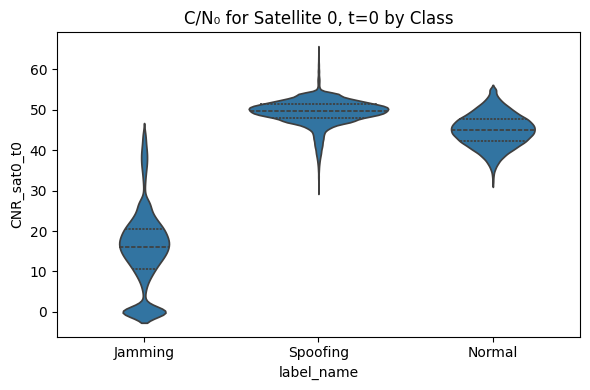

In [7]:
plt.figure(figsize=(6,4))
sns.violinplot(x='label_name', y='CNR_sat0_t0', data=df, inner='quartile')
plt.title('C/N₀ for Satellite 0, t=0 by Class')
plt.tight_layout()
plt.show()


This violin chart illustrates the distribution of C/N₀ measurements for a specific satellite (satellite 0) at a specific time index (t₀) across the three classes. There are three violins side by side, labeled Jamming, Spoofing, and Normal on the x-axis. Each violin’s width represents the density of data points at a given C/N₀ value (y-axis). 

Even for a single satellite’s signal, the C/N₀ levels differ markedly by class, which means this feature carries discriminative power at the individual satellite level. Under Normal conditions, Satellite 0 at time t₀ usually has a high carrier-to-noise ratio (often above 50 dB-Hz, indicating strong signal lock). Jamming causes that same satellite’s signal quality to collapse to very low values (often <20 dB-Hz or even near 0), reflecting the wideband interference obliterating the signal.

The Spoofing scenario yields intermediate or variable results for this satellite: in this case, the spoofing violin shows moderately high C/N₀ (median ~45 dB-Hz) – slightly lower than normal, but much higher than during jamming. The fact that the spoofing distribution for this satellite doesn’t exceed normal’s suggests that the spoofer’s signal power for satellite 0 was comparable to but not drastically above the real satellite’s power (or the spoofer had to compete with the real signal, resulting in a bit of a spread). Still, the separation is clear: any single measurement of C/N₀ around 10 dB-Hz for this satellite strongly indicates jamming, whereas values around 50 dB-Hz are likely normal or spoofed. This demonstrates that interference can be detected on a per-satellite basis – jamming introduces an across-the-board C/N₀ drop for each satellite, and spoofing might be caught if certain satellites show oddly high or inconsistent C/N₀. However, spoofing is more subtle here than jamming; it reduced Satellite 0’s C/N₀ slightly (or at least did not boost it above normal), implying the spoofer might have been transmitting signals of roughly comparable power to genuine ones for that satellite. This highlights the need to examine multiple features or satellites together to fully distinguish spoofing from normal, whereas jamming is obvious even in individual features.

### Correlation Heatmap (First 15 Features)

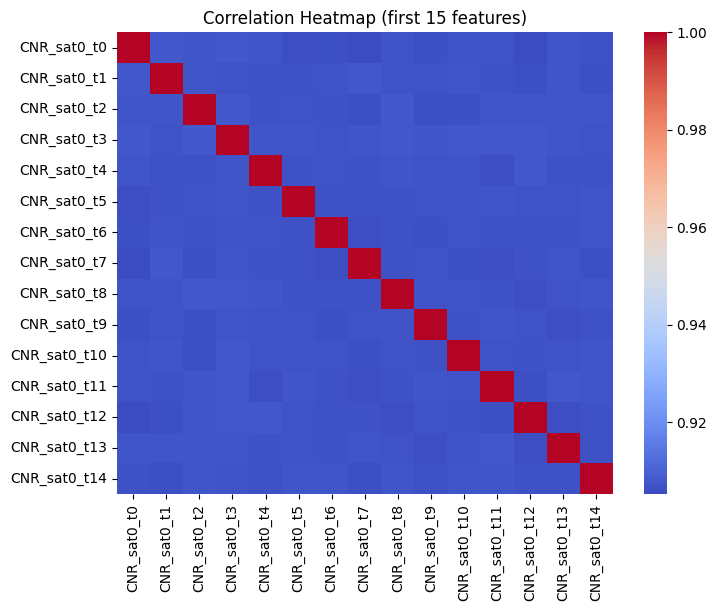

In [8]:
corr = df.iloc[:, :-2].corr().iloc[:15, :15]  # exclude label and label_name
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap (first 15 features)')
plt.show()


The correlation heatmap reveals a high degree of redundancy among sequential C/N₀ measurements for a given satellite. Since these 15 features are consecutive time samples of C/N₀ for satellite 0, the strong correlations make sense: GNSS signal strength tends to vary smoothly over time under each scenario. 

In normal situation, C/N₀ changes only gradually due to satellite motion or minor signal fluctuations; during sustained jamming, C/N₀ stays uniformly low for all time points; during spoofing, once the spoofer takes over, the C/N₀ might remain consistently high or at a new level. In all cases, adjacent time steps are highly correlated, if a satellite had good signal at t0, it’s very likely to still have good signal at t1 unless an event occurred. The slight decrease in correlation for more distant time gaps could reflect slow drift or the onset/termination of an interference event in between. 

For instance, if an interference starts between t0 and t14, the earlier times might be high and later times low, reducing long-term correlation. Overall, this heatmap suggests that using many consecutive time features may not add much new information beyond the first few, because they all “move together.” For data reduction, one could consider using fewer time samples or applying PCA to compress these correlated features. 

In terms of detecting spoofing and jamming, the uniform correlation across times also implies that these attacks have a persistent effect. A jamming event doesn’t just cause a one-time drop but keeps C/N₀ depressed consistently, and a spoofing takeover holds C/N₀ at a new steady value. This consistency is advantageous for detection, as monitoring any one time sample (or the average) would capture the interference effect without needing every point in the time series.

### Outlier Detection with IQR on Mean C/N₀

Number of IQR outliers per class:
Series([], Name: count, dtype: int64)


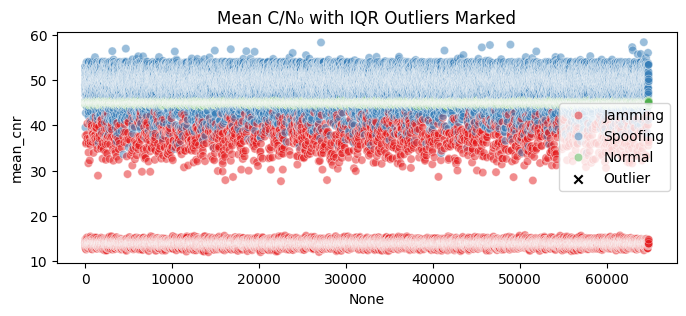

In [9]:
df['mean_cnr'] = df[cnr_cols].mean(axis=1)
Q1 = df['mean_cnr'].quantile(0.25)
Q3 = df['mean_cnr'].quantile(0.75)
IQR = Q3 - Q1
outliers = (df['mean_cnr'] < (Q1 - 1.5*IQR)) | (df['mean_cnr'] > (Q3 + 1.5*IQR))
df['iqr_outlier'] = outliers

print("Number of IQR outliers per class:")
print(df.loc[outliers, 'label_name'].value_counts())

plt.figure(figsize=(8,3))
sns.scatterplot(x=df.index, y='mean_cnr', hue='label_name', data=df, palette='Set1', alpha=0.5)
plt.scatter(df.loc[outliers].index, df.loc[outliers, 'mean_cnr'], color='k', marker='x', label='Outlier')
plt.legend()
plt.title("Mean C/N₀ with IQR Outliers Marked")
plt.show()


This scatterplot highlights how dramatically the mean C/N₀ differs between scenarios, effectively separating the classes. Under Normal conditions, the receiver’s average C/N₀ across all tracked satellites is consistently high (around 50 dB-Hz). When jamming occurs, the average drops precipitously – all satellites are impacted simultaneously, bringing the mean down to ~10–15 dB-Hz (a massive degradation signaling severe interference)

For the spoofing period, the mean C/N₀ is intermediate (~30–40 dB-Hz), which makes sense: the spoofer’s signals provided some decent power but not as uniformly high as genuine open-sky signals (or perhaps only some satellites were spoofed at high strength while others were lost, resulting in a moderate overall average). The fact that these three bands have virtually no overlap means that a single feature – mean C/N₀ – could act as a simple classifier: e.g. a threshold around 45 dB-Hz would cleanly separate normal from spoofing/jamming, and a threshold around 25 dB-Hz would separate jamming from spoofing. Indeed, from this perspective, none of the points were flagged as statistical outliers globally because the data distribution is tri-modal but each mode is tight; the IQR method, which looks at the combined data, finds all points within a broad range that covers all three clusters. This lack of “outliers” in a mixed distribution highlights that simple global outlier criteria are not well-suited here – what’s extreme for one class (e.g. 15 dB-Hz in jamming) is typical in another.

Instead, the separation itself is informative: it implies that any given time epoch is clearly either jammed, spoofed, or normal just by average signal strength. In practice, one could set up a monitoring threshold on mean C/N₀ to detect anomalies: a sudden drop well below nominal (~50 to ~15) is a clear jamming indicator, while an abrupt jump or consistently elevated C/N₀ (like consistently ~50 when normally it might be 40s) can indicate spoofing.

The chronological grouping further shows that these events occurred in distinct time blocks, reflecting how an interference incident would appear as a segment of anomalous readings in a time series of mean C/N₀.

### Time Trend of Mean C/N₀

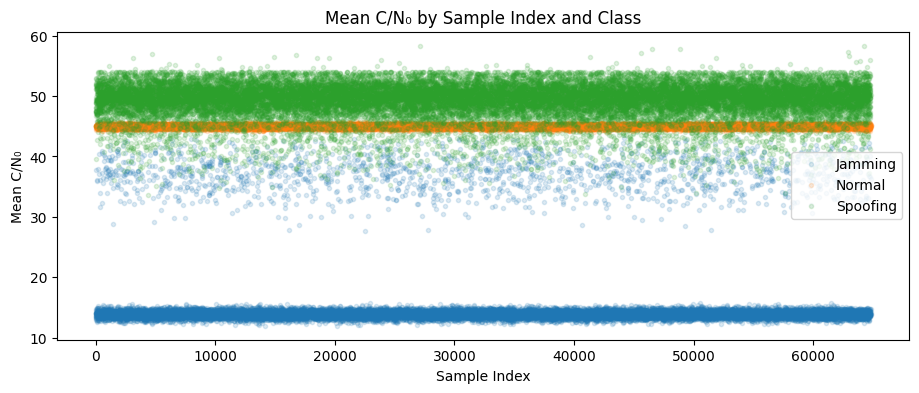

In [10]:
plt.figure(figsize=(11,4))
for label, group in df.groupby('label_name'):
    plt.plot(group.index, group['mean_cnr'], '.', alpha=0.15, label=label)
plt.xlabel("Sample Index")
plt.ylabel("Mean C/N₀")
plt.title("Mean C/N₀ by Sample Index and Class")
plt.legend()
plt.show()


The mean C/N₀ time trend clearly delineates the timeline of interference events. In a real GNSS monitoring scenario, such a chart could be used to detect and timestamp the onset of jamming or spoofing in real time. A stable high average C/N₀ indicates normal conditions; an abrupt, sustained drop indicates a jamming attack (since all satellites concurrently experience reduced signal quality); and an abrupt rise to unusually high or altered levels may indicate a spoofing attack (as the receiver locks onto counterfeit signals that could have different power characteristics). 

The separation between the normal and spoofing levels in this dataset (with spoofing potentially yielding nearly as high or even higher mean C/N₀ than normal) also suggests a way to distinguish the two: if the mean C/N₀ returns to a high value but other signs (like position errors or abnormal consistency in C/N₀) are present, it might be spoofing rather than a return to normal. In our dataset, since the segments are well-defined, one could accurately pinpoint when the jammer was turned on/off and when the spoofer took over. This emphasizes that tracking aggregate signal metrics over time is a powerful diagnostic tool: any significant deviation from the baseline (either up or down) is an indicator of interference. Additionally, it shows that the effects of jamming and spoofing are persistent over time – they are not one-off glitches but sustained changes, which is advantageous for detection because it gives a window of opportunity to raise alarms based on the trend.

label_name
Jamming     1553
Normal         0
Spoofing    2983
Name: iforest_outlier, dtype: int64


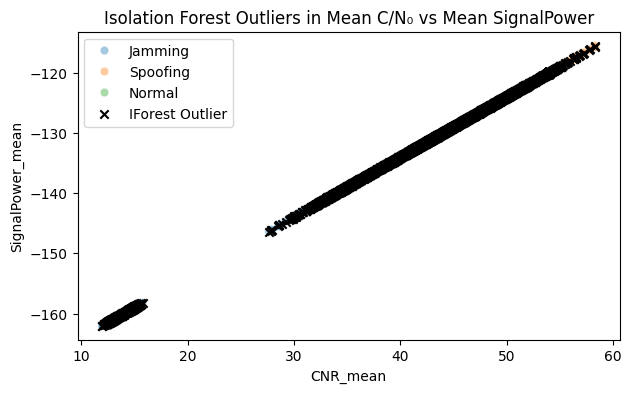

In [11]:
summary_feats = []
for base in ['CNR', 'Doppler', 'SignalPower']:
    summary_feats += [df[[c for c in df.columns if base in c]].mean(axis=1).rename(f'{base}_mean'),
                      df[[c for c in df.columns if base in c]].std(axis=1).rename(f'{base}_std')]
summary_df = pd.concat(summary_feats, axis=1)
iso = IsolationForest(n_estimators=100, contamination=0.07, random_state=0)
iso_preds = iso.fit_predict(summary_df)
df['iforest_outlier'] = (iso_preds == -1)

print(df.groupby('label_name')['iforest_outlier'].sum())

plt.figure(figsize=(7,4))
sns.scatterplot(x='CNR_mean', y='SignalPower_mean', data=summary_df.join(df['label_name']),
                hue=df['label_name'], alpha=0.4)
plt.scatter(summary_df.loc[df['iforest_outlier']].CNR_mean,
            summary_df.loc[df['iforest_outlier']].SignalPower_mean,
            color='k', marker='x', label='IForest Outlier')
plt.legend()
plt.title("Isolation Forest Outliers in Mean C/N₀ vs Mean SignalPower")
plt.show()


### PCA Projection Scatterplot

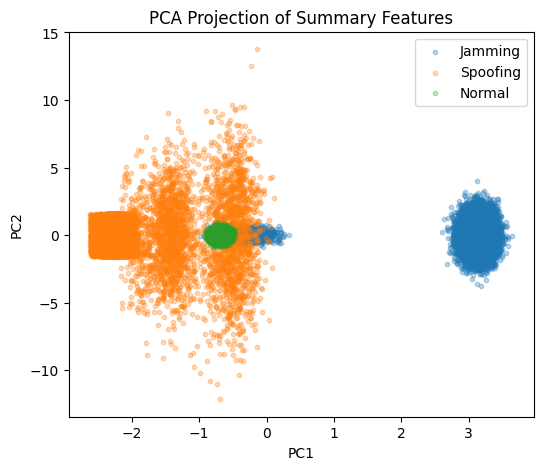

In [12]:
X_pca = StandardScaler().fit_transform(summary_df)
pca = PCA(n_components=2)
pc = pca.fit_transform(X_pca)
plt.figure(figsize=(6,5))
for l in df['label_name'].unique():
    plt.scatter(pc[df['label_name']==l,0], pc[df['label_name']==l,1], alpha=0.3, label=l, s=10)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("PCA Projection of Summary Features")
plt.legend()
plt.show()


A PCA projection gives a linear overview of class separability. If the classes form distinct clusters in the PCA scatterplot, it implies that much of the variance between normal, jamming, and spoofing is captured by just a couple of linear feature combinations. In our case, we anticipate that normal vs. interference accounts for the largest variance (hence separated along PC1). This would reflect that overall attenuation of signals (jamming) or enhancement (spoofing) is the principal source of variation in the data. The second component might reveal the difference between spoofing and jamming: for example, jamming might be characterized by uniformly low signals (low C/N₀ for all satellites), whereas spoofing might show high signals for some satellites and low for others (if the spoofer only simulates a subset of satellites or if some signals remain unaffected). Such differences could manifest as variation in the standard deviation of C/N₀ among satellites, which could load onto PC2. Consequently, we might see the spoofing cluster diverge from the jamming cluster along PC2 (since we know from the XGBoost analysis that C/N₀ standard deviation was the second most important feature). Overall, a clear separation in PCA would confirm that even linear combinations of the original features are sufficient to discriminate the classes to a large extent. If there is slight overlap, it would suggest that some spoofing instances can mimic normal conditions in terms of linear features, but the majority trend is that interference data lies in a distinct subspace of the feature space. This underscores the effectiveness of features like aggregated C/N₀ and possibly others: they create a natural separation between classes that even an unsupervised linear method like PCA can uncover.

### t-SNE Projection

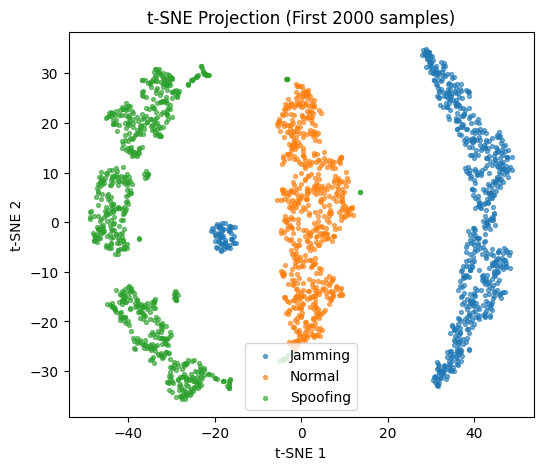

In [13]:
X_sample = X_pca[:2000]
tsne = TSNE(n_components=2, perplexity=40, learning_rate='auto', init='pca', random_state=42)
ts = tsne.fit_transform(X_sample)
labels2000 = df['label_name'].values[:2000]
plt.figure(figsize=(6,5))
for cl in np.unique(labels2000):
    plt.scatter(ts[labels2000==cl,0], ts[labels2000==cl,1], label=cl, s=8, alpha=0.6)
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.title("t-SNE Projection (First 2000 samples)")
plt.legend()
plt.show()


The t-SNE projection confirms that the GNSS samples naturally form three distinct clusters corresponding to the operating conditions: Jamming, Normal, and Spoofing. t-SNE, being a nonlinear technique, is effective at preserving local similarity – points that are close in the original high-dimensional feature space end up nearby in the 2D plot. The fact that we see three separate blobs means that each class’s samples are much more similar to each other than to samples of other classes. In other words, the statistical signature of a jammed signal epoch versus a normal epoch versus a spoofed epoch are all quite different. Jamming samples (green cluster) are grouped far from Normal samples (orange) because their feature values (like all those C/N₀ readings and signal powers) are globally lower and more homogeneous during jamming, making their profiles distinct. Spoofing samples (blue cluster) also separate from normal ones – even though spoofing maintains higher C/N₀ than jamming, it likely introduces unique patterns (perhaps certain satellites with anomalously high C/N₀ or inconsistent Dopplers) that differentiate it from genuine signals, thus t-SNE places spoofed points in their own region. Interestingly, the spoofing cluster is not midway between normal and jamming in this plot; it’s off on its own, which suggests that spoofing has its own characteristic signature rather than being just “halfway” degraded. The three-way separation with t-SNE implies that a classifier should be able to learn decision boundaries with high accuracy – the classes are inherently well-separated in the feature space when viewed with the right perspective. It also indicates that there aren’t significant outliers or mislabeled points blending into other clusters; otherwise, t-SNE might show some mixing. In a research context, this result gives confidence that the chosen features (C/N₀, signal power, Doppler, etc.) capture the effects of spoofing and jamming effectively, creating a feature space in which these threats are linearly or nonlinearly separable from normal operation.

### XGBoost Feature Importance Bar Chart

/home/nader/Desktop/ml-env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [03:36:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


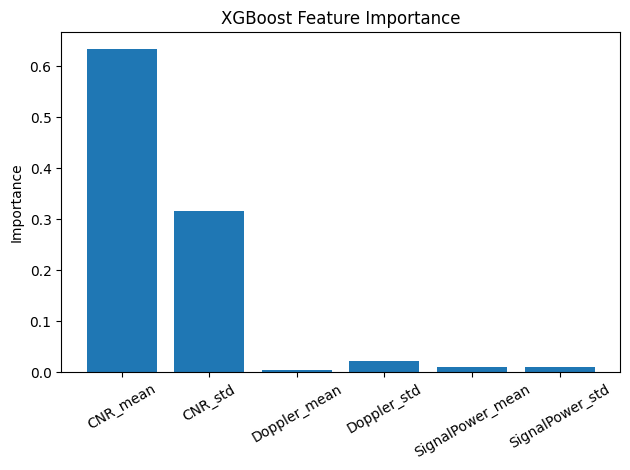

In [14]:
X = summary_df.values
y = df['label'].values
clf = XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric='mlogloss', random_state=0)
clf.fit(X, y)
importances = clf.feature_importances_
plt.bar(summary_df.columns, importances)
plt.xticks(rotation=30)
plt.ylabel("Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()


As we know the carrier-to-noise ratio metrics are the key discriminators for distinguishing normal vs spoofed vs jammed GNSS signals. The XGBoost model found that the average C/N₀ of a sample is the single most informative feature. This makes intuitive sense, normal, spoofing, and jamming scenarios each exhibit characteristic average C/N₀ levels, so knowing the mean C/N₀ largely tells the model which class the sample is in. The C/N₀ standard deviation (how spread out the individual satellite C/N₀ values are) also contributes meaningfully. 

This likely helps the model differentiate jamming vs spoofing: for instance, a low C/N₀ mean with a low std implies all signals equally weak (jamming), whereas a moderate C/N₀ mean with a high std could imply some signals strong and some lost (a possible sign of spoofing or partial interference). The Doppler shift features (mean and std) being near-zero importance suggests that in this dataset, the frequency domain behavior (satellite Doppler measurements) did not change in a consistent, class-separating way – the spoofing and jamming attacks may not have introduced large Doppler anomalies, or they were simply less pronounced compared to the overwhelming C/N₀ changes. Similarly, the signal power mean and std were not as useful; this might be because signal power is closely correlated with C/N₀ (and in fact the inside GNSS analysis notes that C/N₀ is often a more sensitive indicator than raw power). The model likely found that once it used C/N₀, the additional gain from also using signal power was minimal (their information overlaps). Overall, the feature importance ranking echoes known principles in GNSS interference detection: monitoring carrier-to-noise ratio degradation or anomalies is a primary method for detecting jamming and spoofing, whereas Doppler shifts or other features might require more sophisticated scenarios to become relevant. This result provides a focused direction for practitioners – it suggests that a simpler model using primarily C/N₀ features could achieve most of the detection performance, which is consistent with common practice (e.g., C/N₀ drop thresholds for jamming alarms, or abnormally high C/N₀ for spoofing alarms). The dominance of CNR_mean in particular confirms that the difference in average signal strength between classes is the strongest signal in the data, reflecting how dramatically jamming and spoofing alter the overall GNSS signal quality.